In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pickle

# Prediction Using Machine Learning
## Setting up the target column

In [2]:
df = pickle.load(open('clean_df.pkl', 'rb'))
df['result'].value_counts()

W    1950
L     828
D     711
Name: result, dtype: int64

As can be seen from above, the result column is not balanced. Also, according to our brief of predicting if the game is going ot be a win or "not", we will have a binary target column, the result is either a win or loss. Te reason the number of wins is a lot higher than the losses and draws is that these tea have qualified for the Champions League. The qualifying teams win the majority of their games in the domestic leagues as well. 

In [3]:
df = df.sort_values("date")
df=df.reset_index(drop=True)
df.groupby(["venue"]).apply(lambda x: x[x["result"] == 'W'].shape[0]/ x.shape[0])

venue
Away       0.508752
Home       0.612751
Neutral    0.458333
dtype: float64

In [4]:
df.venue.value_counts() # this is not balanced. Have to drop the venues that are neutral. It is only 24 rows. 

Away       1771
Home       1694
Neutral      24
Name: venue, dtype: int64

In [5]:
df = df.loc[df['venue']!='Neutral'] # dropping venue = neutral. 
df.groupby(["venue"]).apply(lambda x: x[x["result"] == 'W'].shape[0]/ x.shape[0]) # So in %62 of the cases, the team wins their home games, as opposed to onl 52% of their away games. 
# This is our benchmark.

venue
Away    0.508752
Home    0.612751
dtype: float64

In [6]:
df['target'] = (df['result'] == "W").astype("int")

## Using a Random Forrest Classifier

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

### Just the initial predictors

In [8]:
predictors = ["venue_code", "opp_code", "hour", "day_code", 'round_code', 'comp_code'] # initial predictors 
rf = RandomForestClassifier(n_estimators=500, min_samples_split=2, random_state=1, class_weight='balanced')
train = df[df['date']< "2022-08-15"] # Using 70% of the rows for training and 30% for testing. cannot do splits since we cannot use future data to predict past games. 
test = df[df['date']> "2022-08-15"]
rf.fit(train[predictors],train['target'])
predictions = rf.predict(test[predictors])
print(train.shape)
print(test.shape)
accuracy_score(test["target"],predictions)
print('accuracy_score =' ,accuracy_score(test["target"],predictions))

(2599, 71)
(863, 71)
accuracy_score = 0.5770567786790266


In [9]:
combined = pd.DataFrame(dict(actual=test["target"], predicted=predictions))
pd.crosstab(index=combined["actual"], columns=combined["predicted"])

predicted,0,1
actual,,
0,177,200
1,165,321


Accuracy score here is not a good measure, we use precision score as we have false positives and false negatives. 0 is a loss and 1 is a win. 

In [10]:
from sklearn.metrics import precision_score
precision_score(test["target"], predictions, average = None) # this shows that we predict %46 for away games and %62 for home games. We need to improve on this.

array([0.51754386, 0.61612284])

In [11]:
precision_score(test["target"], predictions, average = 'weighted')

0.573058789876634

As we can see we do not beat the home/way benchmark only using these features. we will need more features. 

## Feature Engineering
We need to use the rest of the statistics we have to see if we can improve our model. Hence we introduce rolling averages of statistics from previous games as prediction metrics. We have to be careful not to feed any information to the model for predicting a game when we won't have the information. Yu cannot have goals for in the predictors, as that information is known after the game! 

In [12]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("date")
    rolling_stats = group[cols].rolling(5,closed="left").mean() # closed = left -> to avoid data leakage from future matches
    group[new_cols] = rolling_stats
    group = group.dropna(subset = new_cols)
    return group

In [13]:
def make_predictions(data, predictors):
    rf = RandomForestClassifier(n_estimators=1000, min_samples_split=10, random_state=1)
    train = data[data['date']< "2022-8-15"] # Data in order of date use 70% for training
    test = data[data['date']> "2022-8-15"]
    rf.fit(train[predictors],train['target'])
    predictions = rf.predict(test[predictors])
    combined = pd.DataFrame(dict(actual=test["target"], predicted=predictions))
    precision_weight = precision_score(test["target"], predictions, average = 'weighted')
    precision_raw = precision_score(test["target"], predictions, average = None)
    ConfusionMatrixDisplay.from_estimator(rf, test[predictors], test["target"], display_labels=['won','not won'], cmap=plt.cm.Blues, normalize='true')
    return combined, precision_weight, precision_raw, rf.feature_importances_, rf

### Trying some features based on domain knowledge.

The raw precision [Away, Home] is: [0.5795053  0.64259928]
The weighted precision is: 0.6153113211082752


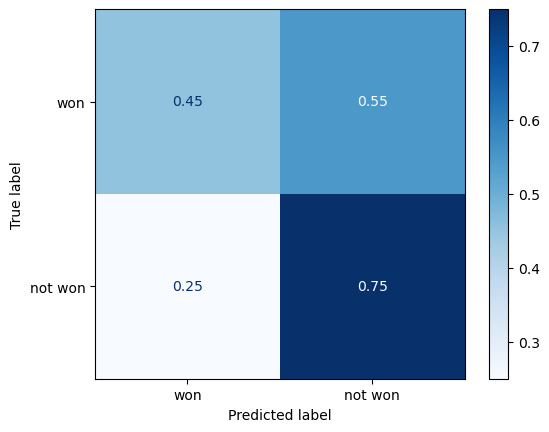

In [14]:
cols = ['gls','gls_opp','gf','gf_opp','sh', 'sot','g/sh','save%_opp','tkl+int','poss_x'] # Choosing based on domain knowledge.
new_cols = [f"{c}_rolling" for c in cols] # add_rolling to column names

df_rolling = df.groupby('team').apply(lambda x: rolling_averages(x,cols,new_cols))
df_rolling = df_rolling.droplevel('team')

combined, precision_weight, precision_raw, importances, rf = make_predictions (df_rolling, predictors+new_cols)

print("The raw precision [Away, Home] is:",precision_raw)
print("The weighted precision is:", precision_weight)

In [15]:
df.groupby(["venue"]).apply(lambda x: x[x["result"] == 'W'].shape[0]/ x.shape[0]) # What we get by predicting home wins, i.e. %62 of the home games are won and %52 of the away games. 

venue
Away    0.508752
Home    0.612751
dtype: float64

We are already over the benchmark with the above stats, but we will try and improve. 

In [16]:
pd.crosstab(index=combined["actual"], columns=combined["predicted"])

predicted,0,1
actual,,
0,164,198
1,119,356


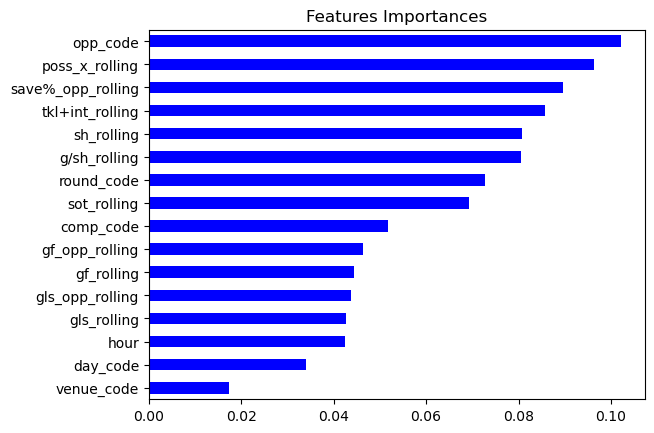

In [17]:
importance = pd.Series(data=importances,
                        index=  predictors+new_cols)
# Sort importances
importances_sorted = importance.sort_values()
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='blue')
plt.title('Features Importances')
plt.show()

### Using all the columns by getting a rolling average for them. 

In [18]:
predictors

['venue_code', 'opp_code', 'hour', 'day_code', 'round_code', 'comp_code']

In [19]:
df.shape

(3465, 71)

[0.59090909 0.63193277]
0.6141901530895838


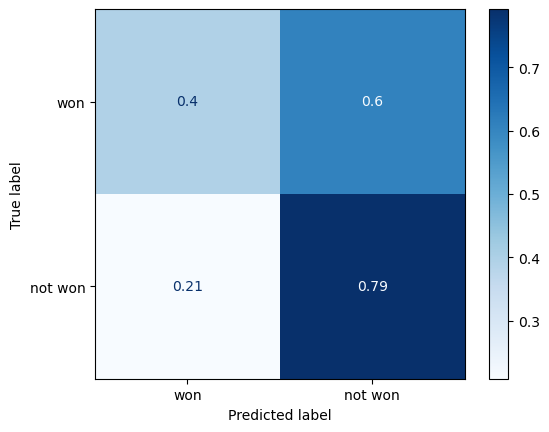

In [20]:
cols = ['gf',
       'gls', 'sh', 'sot', 'sot%', 'g/sh', 'pk', 'pkatt', 'gf_opp', 'gls_opp',
       'sh_opp', 'sot_opp', 'sot%_opp', 'g/sh_opp', 'pk_opp', 'pkatt_opp',
       'sota', 'saves', 'cs', 'pka', 'pksv', 'pkm', 'sota_opp', 'saves_opp',
       'save%_opp', 'cs_opp', 'pka_opp', 'pksv_opp', 'pkm_opp', 'ast',
       'ast_opp', 'crs', 'crs_opp', 'tklw', 'int', 'tkl+int', 'tklw_opp',
       'int_opp', 'tkl+int_opp', 'poss_x', 'poss_opp', 'crdy', 'crdr', '2crdy',
       'fls', 'og', 'crdy_opp', 'crdr_opp', '2crdy_opp', 'fls_opp', 'og_opp',
       ]

rolling_cols = [f"{c}_rolling" for c in cols] # add_rolling to column names

df_rolling = df.groupby('team').apply(lambda x: rolling_averages(x,cols,rolling_cols))
df_rolling = df_rolling.droplevel('team')

all_cols = rolling_cols+predictors

combined, precision_weight, precision_raw, importances, rf = make_predictions (df_rolling, all_cols)

print(precision_raw)
print(precision_weight)

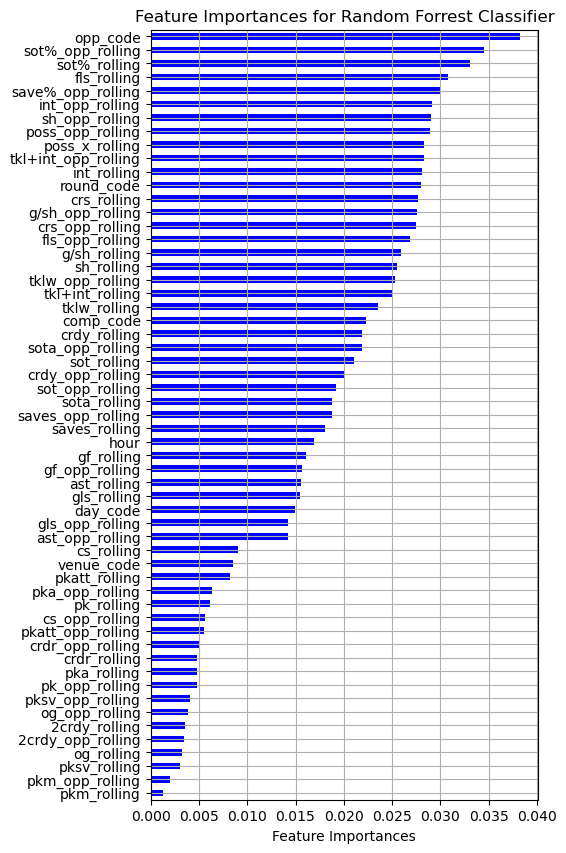

In [21]:
importance = pd.Series(data=importances, index=  all_cols)
# Sort importances
importances_sorted = importance.sort_values()
# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='blue', figsize = (5,10), grid = True, xlabel = 'Feature Importances')
plt.title('Feature Importances for Random Forrest Classifier')
plt.show()

We rank the features based on their importance, and then we prune the least important ones. 

In [22]:
data ={'imp_vals':importances}
imp_df = pd.DataFrame(data=data, index=all_cols)
imp_df.sort_values(by = 'imp_vals')

,imp_vals
pkm_rolling,0.001305
pkm_opp_rolling,0.002032
pksv_rolling,0.003013
og_rolling,0.003258
2crdy_opp_rolling,0.003432
2crdy_rolling,0.003560
og_opp_rolling,0.003860
pksv_opp_rolling,0.004050
pk_opp_rolling,0.004766
pka_rolling,0.004790


[0.5814978  0.62295082]
0.6050225113350468


predicted,0,1
actual,,
0,132,230
1,95,380


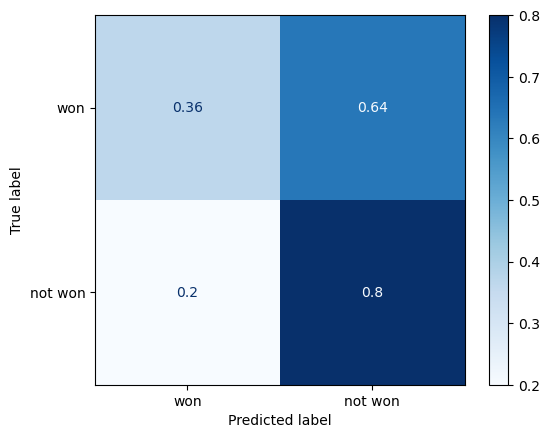

In [23]:
predictors3 = imp_df.loc[imp_df['imp_vals']>0.015].index # Selecting from the chosen features, and removing the east important ones. 
combined, precision_weight, precision_raw, importances,rf = make_predictions (df_rolling, predictors3)

print(precision_raw)
print(precision_weight)

pd.crosstab(index=combined["actual"], columns=combined["predicted"])

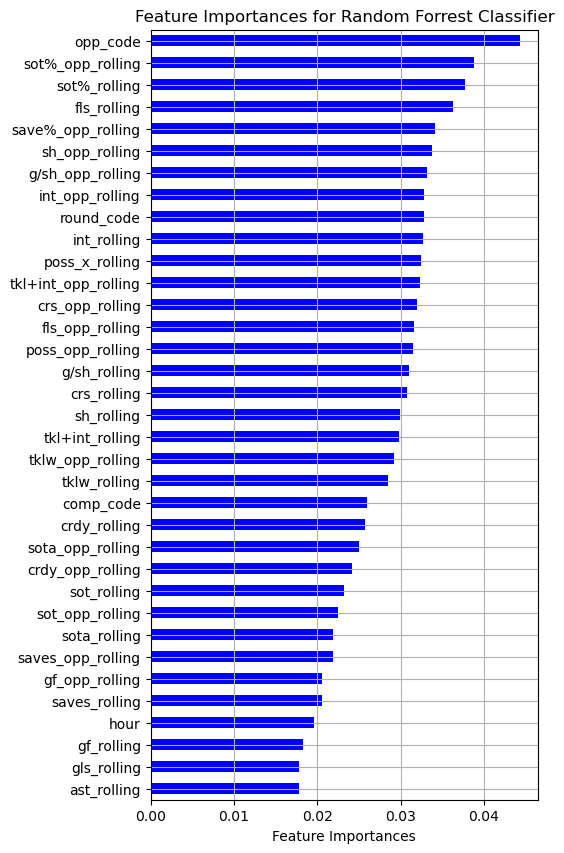

In [24]:
importance = pd.Series(data=importances, index=  predictors3)
# Sort importances
importances_sorted = importance.sort_values()
# Draw a horizontal barplot of importances_sorted

importances_sorted.plot(kind='barh', color='blue',figsize = (5,10), grid = True, xlabel = 'Feature Importances')
plt.title('Feature Importances for Random Forrest Classifier')
plt.show()

## More feature Engineering with summation. 

[0.5625     0.61976549]
0.5949983389668374


predicted,0,1
actual,,
0,135,227
1,105,370


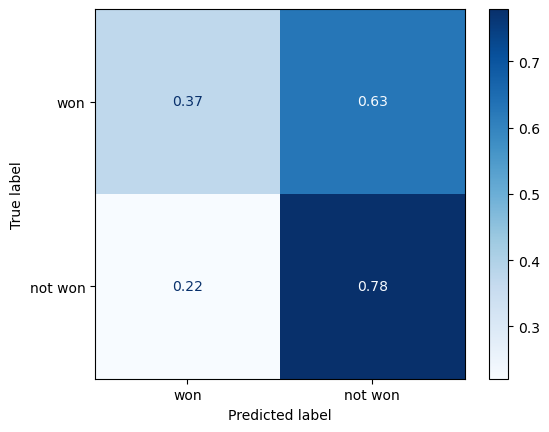

In [25]:
df_rolling["fls_rolling+sot%_rolling"] = df_rolling["fls_rolling"]+df_rolling['sot%_rolling']
predictors3 = list(predictors3) + ["fls_rolling+sot%_rolling"] # Adding two columns together
combined, precision_weight, precision_raw, importances,rf = make_predictions (df_rolling, predictors3)
print(precision_raw)
print(precision_weight)
pd.crosstab(index=combined["actual"], columns=combined["predicted"])


No improvement

In [26]:
len(df[df['season']=='2022-2023']['team'].unique()) #32 teams checks out

32

In [27]:
df.target.value_counts()

1    1939
0    1526
Name: target, dtype: int64

## Prediction Using XGBoost

In [28]:
#Using minmax scaling to prepare for XG boost. 
df_rolling[rolling_cols] = (df_rolling[rolling_cols]-df_rolling[rolling_cols].min())/(df_rolling[rolling_cols].max()-df_rolling[rolling_cols].min())
df_rolling.head() # Normalised now (range between 0,1)

,date,time,comp,round,day,venue,result,gf,opponent,gls,...,crdr_rolling,2crdy_rolling,fls_rolling,og_rolling,crdy_opp_rolling,crdr_opp_rolling,2crdy_opp_rolling,fls_opp_rolling,og_opp_rolling,fls_rolling+sot%_rolling
193,2020-10-21,21:00,Champions Lg,Group stage,Wed,Home,L,0,Liverpool,0.0,...,0.50,0.0,0.376812,0.000000,0.28,0.2,0.0,0.421053,0.0,39.12
224,2020-10-27,21:00,Champions Lg,Group stage,Tue,Away,D,2,Atalanta,2.0,...,0.25,0.0,0.333333,0.333333,0.28,0.2,0.0,0.368421,0.0,36.30
252,2020-10-31,20:00,Eredivisie,Regular season,Sat,Home,W,5,Fortuna Sittard,5.0,...,0.25,0.0,0.449275,0.333333,0.40,0.0,0.0,0.447368,0.0,39.20
283,2020-11-03,21:00,Champions Lg,Group stage,Tue,Away,W,2,Midtjylland,2.0,...,0.00,0.0,0.434783,0.333333,0.28,0.0,0.0,0.394737,0.0,39.74
324,2020-11-08,12:15,Eredivisie,Regular season,Sun,Away,W,3,Utrecht,3.0,...,0.00,0.0,0.579710,0.333333,0.32,0.0,0.0,0.500000,0.0,55.52


In [29]:
def make_xgb_predictions(XGB_model, data, predictors):
    train = data[data['date']< "2022-8-15"] # Data in order of date use 70% for training
    test = data[data['date']> "2022-8-15"]
    
    eval_set = [(train[predictors], train['target']), (test[predictors], test['target'])]

    XGB_model.fit(train[predictors],train['target'], eval_set=eval_set, verbose=True)

    predictions = XGB_model.predict(test[predictors])

    combined = pd.DataFrame(dict(actual=test["target"], predicted=predictions))

    precision_weight = precision_score(test["target"], predictions, average = 'weighted')
    precision_raw = precision_score(test["target"], predictions, average = None)

    return combined, precision_weight, precision_raw, XGB_model.feature_importances_, XGB_model

In [30]:
import xgboost as xgb

#XGBClassifier default parameters are not available without fitting the model
XGB_model = xgb.XGBClassifier(verbosity = 0,
                              objective='binary:logistic',
                              booster='gbtree',
                              eta = 0.01,
                              eval_metric='auc',
                              max_depth = 2,
                              max_delta_step = 10,
                              subsample = 0.1,
                              reg_lambda = 1.1,
                              reg_alpha = 0.6,
                              tree_method = 'exact',
                              scale_pos_weight = 0.76,
                              )
#XGB_model.get_params()
combined, precision_weight, precision_raw, importances,XGB_model = make_xgb_predictions (XGB_model,df_rolling, predictors+new_cols)
print(precision_raw)
print(precision_weight)
a = pd.crosstab(index=combined["actual"], columns=combined["predicted"])
#Have to divide by the sum of each row to maintain consistancy with the random forrest confusion matrix plots. 
a = a.div(a.sum(axis=1), axis = 0)
import plotly.express as px
fig = px.imshow(a, color_continuous_scale='blues', text_auto=True, x = ['won', 'not won'], y = ['won','not won'])
fig.show()

[0]	validation_0-auc:0.46915	validation_1-auc:0.46654
[1]	validation_0-auc:0.52374	validation_1-auc:0.52078
[2]	validation_0-auc:0.55666	validation_1-auc:0.56215
[3]	validation_0-auc:0.57179	validation_1-auc:0.56691
[4]	validation_0-auc:0.58453	validation_1-auc:0.57663
[5]	validation_0-auc:0.58638	validation_1-auc:0.57249
[6]	validation_0-auc:0.59164	validation_1-auc:0.57277
[7]	validation_0-auc:0.58995	validation_1-auc:0.57107
[8]	validation_0-auc:0.59072	validation_1-auc:0.58104
[9]	validation_0-auc:0.60073	validation_1-auc:0.59464
[10]	validation_0-auc:0.60931	validation_1-auc:0.60056
[11]	validation_0-auc:0.60916	validation_1-auc:0.60014
[12]	validation_0-auc:0.61183	validation_1-auc:0.60263
[13]	validation_0-auc:0.61215	validation_1-auc:0.60716
[14]	validation_0-auc:0.61375	validation_1-auc:0.61079
[15]	validation_0-auc:0.61610	validation_1-auc:0.61235
[16]	validation_0-auc:0.62094	validation_1-auc:0.60753
[17]	validation_0-auc:0.62279	validation_1-auc:0.61242
[18]	validation_0-au

In [31]:
combined

,actual,predicted
2645,1,1
2680,1,1
2708,1,1
2748,1,1
2769,1,1
...,...,...
3462,0,0
2869,0,0
2942,0,0
3035,0,0


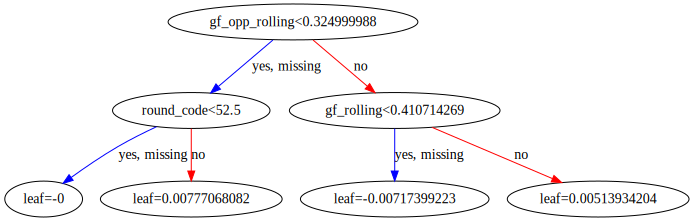

In [33]:
#Available importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']

f = 'gain'
# print(len(XGB_model.get_booster().get_score(importance_type= f)))
# XGB_model.get_booster().get_score(importance_type= f)

xgb_imp = pd.Series(XGB_model.get_booster().get_score(importance_type= f))
xgb_imp = xgb_imp/len(predictors3)



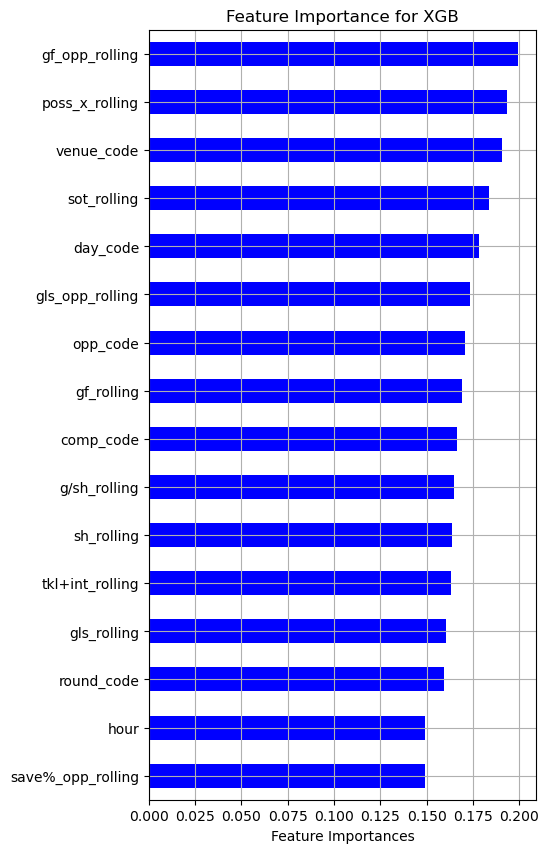

In [34]:
# Sort importances
xgb_imp_sorted = xgb_imp.sort_values()
# Draw a horizontal barplot of importances_sorted
xgb_imp_sorted.plot(kind='barh', color='blue', figsize = (5,10), grid = True, xlabel = 'Feature Importances')
plt.title('Feature Importance for XGB')
plt.show()

Overall we have performance improvement

We note that these Random Forrest and XGBoost are similar but not models not same ( Random forest uses bagging ensemble model while XGBoost uses boosting ensemble model), so it may differ sometimes in results. Now let me tell you why this happens.

When the correlation between the variables are high, XGBoost will pick one feature and may use it while breaking down the tree further(if required) and it will ignore some/all the other remaining correlated features(because we will not be able to learn different aspects of the model by using these correlated feature because it is already highly correlated with the chosen feature).

But in random forest , the tree is not built from specific features, rather there is random selection of features (by using row sampling and column sampling), and then the model in whole learn different correlations of different features. So you can see the procedure of two methods are different so you can expect them to behave little differently.

In [35]:
# Adding the best model to Pickle

file = open('appData.pickle', 'wb')
data = [combined, precision_weight, precision_raw, XGB_model, all_cols, df_rolling]
# dump information to that file
pickle.dump(data, file)
file.close()

In [36]:
len(all_cols)

57

In [37]:

graph = xgb.to_graphviz(XGB_model, num_trees=2)
#st.graphviz_chart(g)
#g = graph.render(view=False)


In [38]:
from PIL import Image
image = Image.open('Deploy1.png')
#st.image(image, caption='XGBoost Tree')

In [39]:
selected_team = 'Celtic' #input("Select Team ")
selected_opponent = 'Ajax' # input("Select Op_Team ")
v_code = 1 #input('v code 1 or 0')

## Setting up the data to be fed into the model.
tm_df = df_rolling[df_rolling['team'] == selected_team].tail(1) # get the last game row for the team. It has the latest rolling stats.
tm_df = tm_df[predictors+new_cols]
tm_df['opp_code'] = int(df_rolling[df_rolling['opponent']==selected_opponent]['opp_code'].head(1))
tm_df['opponent'] = selected_opponent
#tm_df['venue'] = selected_venue
tm_df['venue_code'] = v_code

In [40]:
prediction = XGB_model.predict(tm_df[predictors+new_cols])
prediction
# if prediction == 1:
#     print(selected_team ,""" will **WIN** the match""")
# else:
#    print(selected_team ,"""  will **NOT WIN** the match""")


array([1])

In [41]:
prediction = rf.predict(tm_df[all_cols])
prediction

KeyError: "['sot%_rolling', 'pk_rolling', 'pkatt_rolling', 'sh_opp_rolling', 'sot_opp_rolling', 'sot%_opp_rolling', 'g/sh_opp_rolling', 'pk_opp_rolling', 'pkatt_opp_rolling', 'sota_rolling', 'saves_rolling', 'cs_rolling', 'pka_rolling', 'pksv_rolling', 'pkm_rolling', 'sota_opp_rolling', 'saves_opp_rolling', 'cs_opp_rolling', 'pka_opp_rolling', 'pksv_opp_rolling', 'pkm_opp_rolling', 'ast_rolling', 'ast_opp_rolling', 'crs_rolling', 'crs_opp_rolling', 'tklw_rolling', 'int_rolling', 'tklw_opp_rolling', 'int_opp_rolling', 'tkl+int_opp_rolling', 'poss_opp_rolling', 'crdy_rolling', 'crdr_rolling', '2crdy_rolling', 'fls_rolling', 'og_rolling', 'crdy_opp_rolling', 'crdr_opp_rolling', '2crdy_opp_rolling', 'fls_opp_rolling', 'og_opp_rolling'] not in index"

In [ ]:
tm_df

,venue_code,opp_code,hour,day_code,round_code,comp_code,gls_rolling,gls_opp_rolling,gf_rolling,gf_opp_rolling,sh_rolling,sot_rolling,g/sh_rolling,save%_opp_rolling,tkl+int_rolling,poss_x_rolling,opponent
3706,1,14,12,6,57,20,0.535714,0.05,0.533333,0.05,0.534653,0.389831,0.6,0.342147,0.0,0.979253,Ajax


In [ ]:
df_rolling

,date,time,comp,round,day,venue,result,gf,opponent,gls,...,crdr_rolling,2crdy_rolling,fls_rolling,og_rolling,crdy_opp_rolling,crdr_opp_rolling,2crdy_opp_rolling,fls_opp_rolling,og_opp_rolling,fls_rolling+sot%_rolling
193,2020-10-21,21:00,Champions Lg,Group stage,Wed,Home,L,0,Liverpool,0.0,...,0.50,0.0,0.351351,0.000000,0.269231,0.2,0.0,0.421053,0.0,39.12
222,2020-10-24,16:30,Eredivisie,Regular season,Sat,Away,W,13,VVV-Venlo,13.0,...,0.25,0.0,0.310811,0.333333,0.269231,0.2,0.0,0.368421,0.0,36.30
241,2020-10-27,21:00,Champions Lg,Group stage,Tue,Away,D,2,Atalanta,2.0,...,0.25,0.0,0.324324,0.333333,0.307692,0.2,0.0,0.447368,0.0,37.80
266,2020-10-31,20:00,Eredivisie,Regular season,Sat,Home,W,5,Fortuna Sittard,5.0,...,0.00,0.0,0.364865,0.333333,0.269231,0.2,0.0,0.407895,0.0,43.96
291,2020-11-03,21:00,Champions Lg,Group stage,Tue,Away,W,2,Midtjylland,2.0,...,0.00,0.0,0.405405,0.333333,0.307692,0.2,0.0,0.421053,0.0,47.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2582,2022-04-25,19:00,Premier League,Matchweek 26,Mon,Away,W,3,Krasnodar,3.0,...,0.25,0.5,0.297297,0.000000,0.653846,0.0,0.0,0.565789,0.0,45.62
2599,2022-04-30,19:30,Premier League,Matchweek 27,Sat,Home,W,3,Loko Moscow,3.0,...,0.00,0.0,0.216216,0.000000,0.615385,0.0,0.0,0.500000,0.0,46.04
2641,2022-05-07,16:30,Premier League,Matchweek 28,Sat,Home,W,1,FC Khimki,1.0,...,0.00,0.0,0.148649,0.000000,0.576923,0.0,0.0,0.447368,0.0,46.86
2691,2022-05-15,16:30,Premier League,Matchweek 29,Sun,Away,D,1,Spartak Moscow,1.0,...,0.00,0.0,0.324324,0.000000,0.500000,0.0,0.0,0.381579,0.0,56.96
